DataFrame Columns after cleaning: ['Gene ID', 'WT_D1_1', 'WT_D1_2', 'WT_D10_1', 'WT_D10_2', 'WT_D30_1', 'WT_D30_2', 'A30P_D1_1', 'A30P_D1_2', 'A30P_D10_1', 'A30P_D10_2', 'A53T_D1_1', 'A53T_D1_2', 'A53T_D10_1', 'A53T_D10_2', 'A53T_D30_1', 'A53T_D30_2']


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


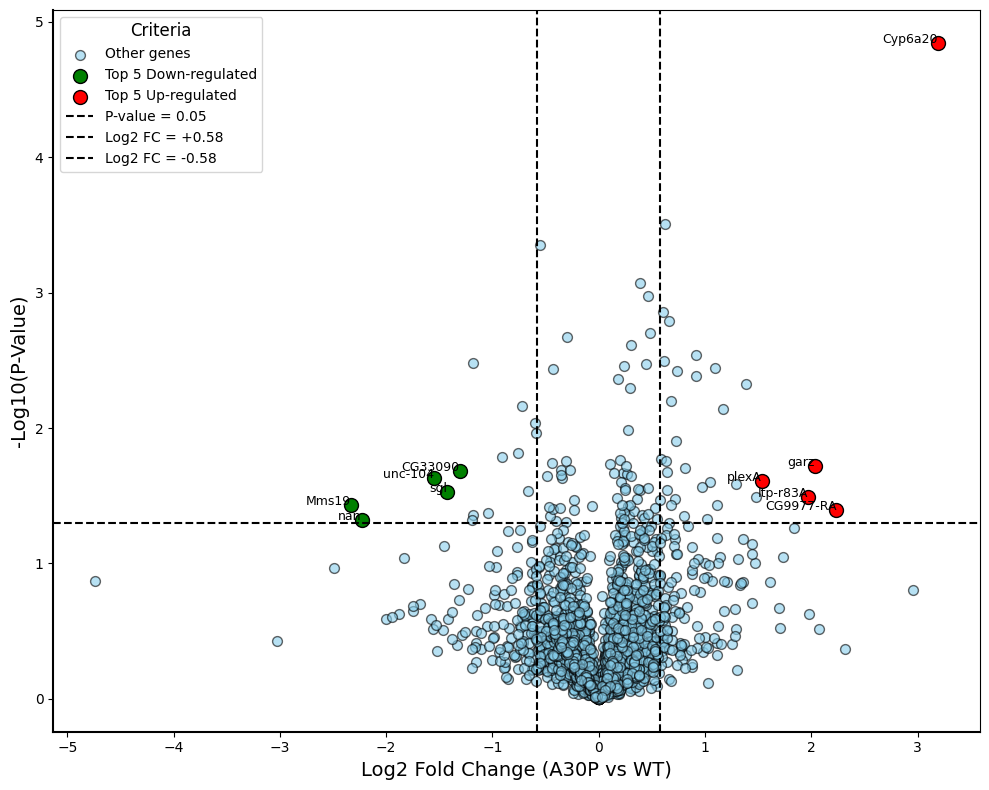

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Phartyma/Python-Biology-Finals/refs/heads/main/Alpha%20synuclein%20Final%20Project.%20Log%20transformed.csv'
df = pd.read_csv(url)

# --- Start of suggested changes ---
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Replace '#VALUE!' with NaN and convert relevant columns to numeric
# First, identify all columns that are expected to be numeric (excluding 'Gene ID' if it exists)
numeric_cols = [col for col in df.columns if col not in ['Gene ID']]

# Replace '#VALUE!' string in these columns and then convert to numeric
for col in numeric_cols:
    df[col] = df[col].replace('#VALUE!', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Print actual column names for verification
print("DataFrame Columns after cleaning:", df.columns.tolist())
# --- End of suggested changes ---

# Calculate mean for WT and A30P replicates
df['WT_Mean'] = df[['WT_D1_1', 'WT_D1_2', 'WT_D10_1', 'WT_D10_2', 'WT_D30_1', 'WT_D30_2']].mean(axis=1)
df['A30P_Mean'] = df[['A30P_D1_1', 'A30P_D1_2', 'A30P_D10_1', 'A30P_D10_2']].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['A30P_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['A30P_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['WT_D1_1', 'WT_D1_2', 'WT_D10_1', 'WT_D10_2', 'WT_D30_1', 'WT_D30_2']].values,
    df[['A30P_D1_1', 'A30P_D1_2', 'A30P_D10_1', 'A30P_D10_2']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# Define significance thresholds
p_threshold = 0.05
fc_threshold = 0.58

# Filter for all significant genes first based on both P-value and Fold Change thresholds
significant_genes_df = df[(df['P_Value'] < p_threshold) & (abs(df['Log2_FC']) >= fc_threshold)]

# Get top 5 down-regulated genes (most negative Log2_FC) from the significant genes
top_5_down_regulated = significant_genes_df[significant_genes_df['Log2_FC'] < -fc_threshold].nsmallest(5, 'Log2_FC')

# Get top 5 up-regulated genes (most positive Log2_FC) from the significant genes
top_5_up_regulated = significant_genes_df[significant_genes_df['Log2_FC'] >= fc_threshold].nlargest(5, 'Log2_FC')

# Combine these for labeling on the plot
top_genes = pd.concat([top_5_down_regulated, top_5_up_regulated])

# Create the volcano plot
plt.figure(figsize=(10, 8))

# Plot all genes as 'Other genes' (this includes non-significant and significant but not top 5)
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB', label='Other genes')

# Highlight only the top 5 down-regulated genes
plt.scatter(top_5_down_regulated['Log2_FC'], top_5_down_regulated['MinusLog10_P'], color='green', s=100, edgecolor='black', marker='o', label='Top 5 Down-regulated')

# Highlight only the top 5 up-regulated genes
plt.scatter(top_5_up_regulated['Log2_FC'], top_5_up_regulated['MinusLog10_P'], color='red', s=100, edgecolor='black', marker='o', label='Top 5 Up-regulated')

# Add gene labels for the actual top 5 up and down regulated genes
for _, row in top_genes.iterrows():
    # Assuming 'Gene ID' is the correct column for gene names
    if 'Gene ID' in row.index:
        plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene ID'], fontsize=9, ha='right')
    else:
        # Fallback if 'Gene ID' is not present, though it should be after loading the CSV
        plt.text(row['Log2_FC'], row['MinusLog10_P'], "Unknown Gene", fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(p_threshold), color='black', linestyle='--', label=f'P-value = {p_threshold}')
plt.axvline(fc_threshold, color='black', linestyle='--', label=f'Log2 FC = +{fc_threshold}')
plt.axvline(-fc_threshold, color='black', linestyle='--', label=f'Log2 FC = -{fc_threshold}')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (A30P vs WT)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('volcano_plot.pdf')

# Show the plot
plt.show()

In [4]:
top_genes

,Gene ID,WT_D1_1,WT_D1_2,WT_D10_1,WT_D10_2,WT_D30_1,WT_D30_2,A30P_D1_1,A30P_D1_2,A30P_D10_1,...,A53T_D1_2,A53T_D10_1,A53T_D10_2,A53T_D30_1,A53T_D30_2,WT_Mean,A30P_Mean,Log2_FC,P_Value,MinusLog10_P
1351,Mms19,NaN,0.242816,NaN,NaN,NaN,NaN,-2.167410,-2.010134,NaN,...,NaN,NaN,NaN,NaN,NaN,0.242816,-2.088772,-2.331588,0.037147,1.430074
2542,NaN,1.890096,1.554491,NaN,NaN,2.251234,NaN,NaN,0.520146,NaN,...,NaN,NaN,NaN,NaN,NaN,1.898607,-0.332845,-2.231452,0.047521,1.323117
2583,unc-104,-0.334953,-1.767388,-1.771175,0.237197,-0.549768,-1.480317,-1.941088,-2.794858,NaN,...,-1.568965,NaN,-1.994701,-1.914684,-1.042338,-0.944401,-2.496128,-1.551727,0.023296,1.632719
250,sgl,NaN,0.040682,NaN,NaN,NaN,NaN,-1.391039,-1.819037,-1.028734,...,0.234133,NaN,-0.796435,NaN,-0.027807,0.040682,-1.387911,-1.428593,0.029739,1.526674
3713,CG33090,-1.442026,-0.212517,-0.898215,NaN,0.068602,NaN,-1.745164,-1.652992,-2.662917,...,NaN,NaN,-1.176218,0.126709,NaN,-0.621039,-1.927870,-1.306831,0.020863,1.680628
4426,Cyp6a20,0.169027,0.085833,0.175684,0.255561,0.065572,0.108491,2.294694,4.081254,4.003152,...,NaN,3.359240,3.484267,2.021302,NaN,0.143361,3.334792,3.191431,0.000014,4.844193
4260,CG9977-RA,-1.679966,-1.778729,-0.791208,-2.053613,-2.128850,-2.223037,1.750435,2.906179,-1.607441,...,-1.605903,-1.399844,-1.497893,-1.636930,-1.450203,-1.775901,0.460328,2.236229,0.040366,1.393983
344,garz,-2.011123,-2.499810,NaN,NaN,NaN,NaN,-0.075687,-0.368290,NaN,...,NaN,NaN,NaN,NaN,NaN,-2.255466,-0.221989,2.033477,0.019056,1.719969
719,Itp-r83A,-1.864019,NaN,-2.532074,-2.017826,NaN,NaN,0.440314,-0.772850,NaN,...,NaN,NaN,NaN,-2.211231,NaN,-2.137973,-0.166268,1.971705,0.032494,1.488193
4378,plexA,-2.189351,-2.006594,-1.798717,-1.878162,-2.447643,-2.761702,-1.173645,-2.121047,0.978781,...,1.356257,-1.181608,NaN,-1.521266,-2.108487,-2.180362,-0.643981,1.536381,0.024412,1.612400


DataFrame Columns after cleaning: ['Gene ID', 'WT_D1_1', 'WT_D1_2', 'WT_D10_1', 'WT_D10_2', 'WT_D30_1', 'WT_D30_2', 'A30P_D1_1', 'A30P_D1_2', 'A30P_D10_1', 'A30P_D10_2', 'A53T_D1_1', 'A53T_D1_2', 'A53T_D10_1', 'A53T_D10_2', 'A53T_D30_1', 'A53T_D30_2']


/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df
/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


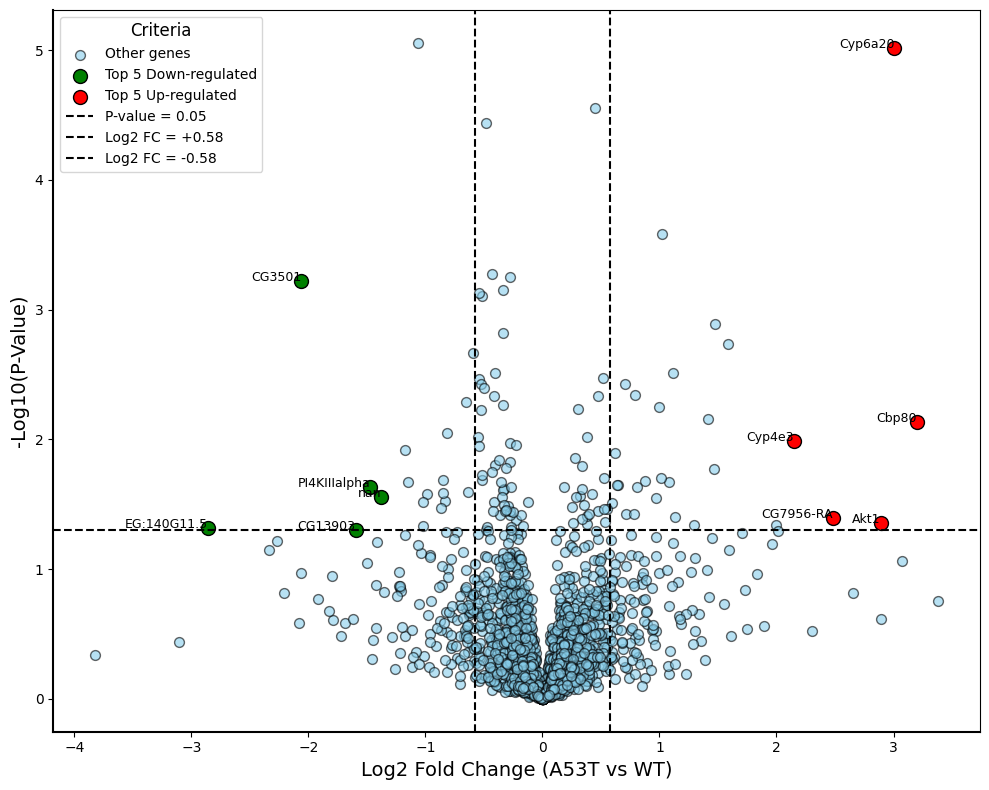

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Phartyma/Python-Biology-Finals/refs/heads/main/Alpha%20synuclein%20Final%20Project.%20Log%20transformed.csv'
df = pd.read_csv(url)

# --- Start of suggested changes ---
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Replace '#VALUE!' with NaN and convert relevant columns to numeric
# First, identify all columns that are expected to be numeric (excluding 'Gene ID' if it exists)
numeric_cols = [col for col in df.columns if col not in ['Gene ID']]

# Replace '#VALUE!' string in these columns and then convert to numeric
for col in numeric_cols:
    df[col] = df[col].replace('#VALUE!', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Print actual column names for verification
print("DataFrame Columns after cleaning:", df.columns.tolist())
# --- End of suggested changes ---

# Calculate mean for WT and A30P replicates
df['WT_Mean'] = df[['WT_D1_1', 'WT_D1_2', 'WT_D10_1', 'WT_D10_2', 'WT_D30_1', 'WT_D30_2']].mean(axis=1)
df['A53T_Mean'] = df[['A53T_D1_1', 'A53T_D1_2', 'A53T_D10_1', 'A53T_D10_2', 'A53T_D30_1', 'A53T_D30_2']].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['A30P_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['A53T_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['WT_D1_1', 'WT_D1_2', 'WT_D10_1', 'WT_D10_2', 'WT_D30_1', 'WT_D30_2']].values,
    df[['A53T_D1_1', 'A53T_D1_2', 'A53T_D10_1', 'A53T_D10_2', 'A53T_D30_1', 'A53T_D30_2']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# Define significance thresholds
p_threshold = 0.05
fc_threshold = 0.58

# Filter for all significant genes first based on both P-value and Fold Change thresholds
significant_genes_df = df[(df['P_Value'] < p_threshold) & (abs(df['Log2_FC']) >= fc_threshold)]

# Get top 5 down-regulated genes (most negative Log2_FC) from the significant genes
top_5_down_regulated = significant_genes_df[significant_genes_df['Log2_FC'] < -fc_threshold].nsmallest(5, 'Log2_FC')

# Get top 5 up-regulated genes (most positive Log2_FC) from the significant genes
top_5_up_regulated = significant_genes_df[significant_genes_df['Log2_FC'] >= fc_threshold].nlargest(5, 'Log2_FC')

# Combine these for labeling on the plot
top_genes = pd.concat([top_5_down_regulated, top_5_up_regulated])

# Create the volcano plot
plt.figure(figsize=(10, 8))

# Plot all genes as 'Other genes' (this includes non-significant and significant but not top 5)
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB', label='Other genes')

# Highlight only the top 5 down-regulated genes
plt.scatter(top_5_down_regulated['Log2_FC'], top_5_down_regulated['MinusLog10_P'], color='green', s=100, edgecolor='black', marker='o', label='Top 5 Down-regulated')

# Highlight only the top 5 up-regulated genes
plt.scatter(top_5_up_regulated['Log2_FC'], top_5_up_regulated['MinusLog10_P'], color='red', s=100, edgecolor='black', marker='o', label='Top 5 Up-regulated')

# Add gene labels for the actual top 5 up and down regulated genes
for _, row in top_genes.iterrows():
    # Assuming 'Gene ID' is the correct column for gene names
    if 'Gene ID' in row.index:
        plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene ID'], fontsize=9, ha='right')
    else:
        # Fallback if 'Gene ID' is not present, though it should be after loading the CSV
        plt.text(row['Log2_FC'], row['MinusLog10_P'], "Unknown Gene", fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(p_threshold), color='black', linestyle='--', label=f'P-value = {p_threshold}')
plt.axvline(fc_threshold, color='black', linestyle='--', label=f'Log2 FC = +{fc_threshold}')
plt.axvline(-fc_threshold, color='black', linestyle='--', label=f'Log2 FC = -{fc_threshold}')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (A53T vs WT)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('volcano_plot2.pdf')

# Show the plot
plt.show()

DataFrame Columns after cleaning: ['Gene ID', 'WT_D1_1', 'WT_D1_2', 'WT_D10_1', 'WT_D10_2', 'WT_D30_1', 'WT_D30_2', 'A30P_D1_1', 'A30P_D1_2', 'A30P_D10_1', 'A30P_D10_2', 'A53T_D1_1', 'A53T_D1_2', 'A53T_D10_1', 'A53T_D10_2', 'A53T_D30_1', 'A53T_D30_2']


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


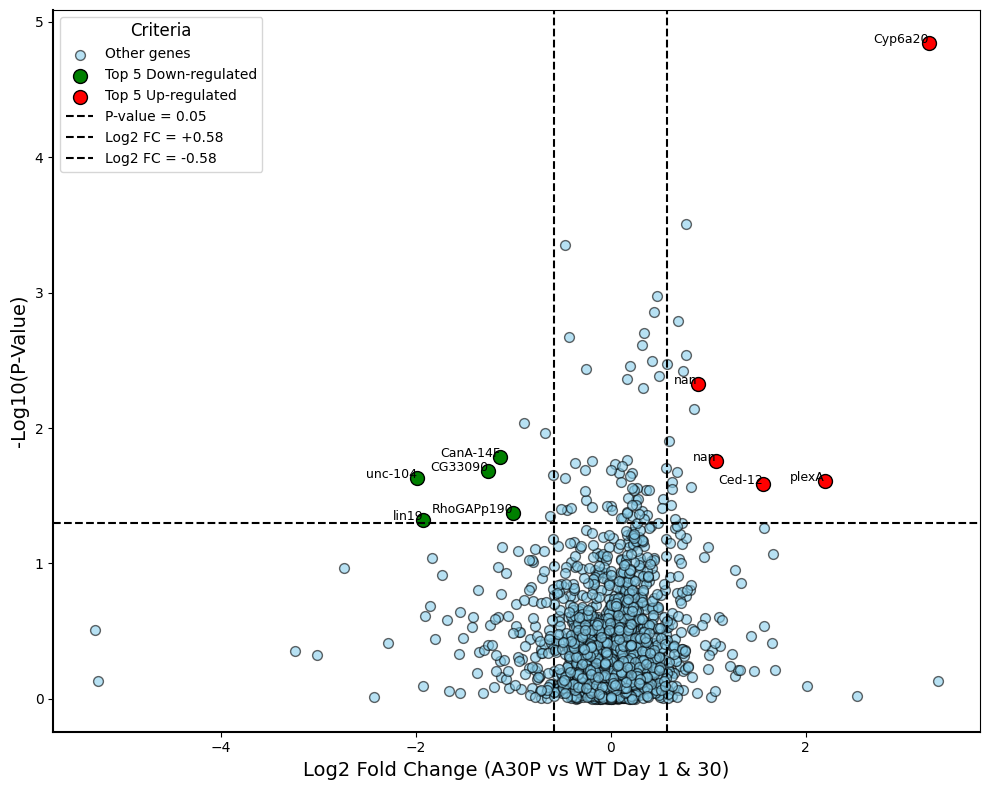

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Phartyma/Python-Biology-Finals/refs/heads/main/Alpha%20synuclein%20Final%20Project.%20Log%20transformed.csv'
df = pd.read_csv(url)

# --- Start of suggested changes ---
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Replace '#VALUE!' with NaN and convert relevant columns to numeric
# First, identify all columns that are expected to be numeric (excluding 'Gene ID' if it exists)
numeric_cols = [col for col in df.columns if col not in ['Gene ID']]

# Replace '#VALUE!' string in these columns and then convert to numeric
for col in numeric_cols:
    df[col] = df[col].replace('#VALUE!', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Print actual column names for verification
print("DataFrame Columns after cleaning:", df.columns.tolist())
# --- End of suggested changes ---

# Calculate mean for WT and A30P replicates
df['WT_Mean'] = df[['WT_D10_1', 'WT_D10_2']].mean(axis=1)
df['A30P_Mean'] = df[['A30P_D10_1', 'A30P_D10_2']].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['A30P_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['A30P_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['WT_D1_1', 'WT_D1_2', 'WT_D10_1', 'WT_D10_2', 'WT_D30_1', 'WT_D30_2']].values,
    df[['A30P_D1_1', 'A30P_D1_2', 'A30P_D10_1', 'A30P_D10_2']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# Define significance thresholds
p_threshold = 0.05
fc_threshold = 0.58

# Filter for all significant genes first based on both P-value and Fold Change thresholds
significant_genes_df = df[(df['P_Value'] < p_threshold) & (abs(df['Log2_FC']) >= fc_threshold)]

# Get top 5 down-regulated genes (most negative Log2_FC) from the significant genes
top_5_down_regulated = significant_genes_df[significant_genes_df['Log2_FC'] < -fc_threshold].nsmallest(5, 'Log2_FC')

# Get top 5 up-regulated genes (most positive Log2_FC) from the significant genes
top_5_up_regulated = significant_genes_df[significant_genes_df['Log2_FC'] >= fc_threshold].nlargest(5, 'Log2_FC')

# Combine these for labeling on the plot
top_genes = pd.concat([top_5_down_regulated, top_5_up_regulated])

# Create the volcano plot
plt.figure(figsize=(10, 8))

# Plot all genes as 'Other genes' (this includes non-significant and significant but not top 5)
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB', label='Other genes')

# Highlight only the top 5 down-regulated genes
plt.scatter(top_5_down_regulated['Log2_FC'], top_5_down_regulated['MinusLog10_P'], color='green', s=100, edgecolor='black', marker='o', label='Top 5 Down-regulated')

# Highlight only the top 5 up-regulated genes
plt.scatter(top_5_up_regulated['Log2_FC'], top_5_up_regulated['MinusLog10_P'], color='red', s=100, edgecolor='black', marker='o', label='Top 5 Up-regulated')

# Add gene labels for the actual top 5 up and down regulated genes
for _, row in top_genes.iterrows():
    # Assuming 'Gene ID' is the correct column for gene names
    if 'Gene ID' in row.index:
        plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene ID'], fontsize=9, ha='right')
    else:
        # Fallback if 'Gene ID' is not present, though it should be after loading the CSV
        plt.text(row['Log2_FC'], row['MinusLog10_P'], "Unknown Gene", fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(p_threshold), color='black', linestyle='--', label=f'P-value = {p_threshold}')
plt.axvline(fc_threshold, color='black', linestyle='--', label=f'Log2 FC = +{fc_threshold}')
plt.axvline(-fc_threshold, color='black', linestyle='--', label=f'Log2 FC = -{fc_threshold}')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (A30P vs WT Day 1 & 30)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('volcano_plota.pdf')

# Show the plot
plt.show()

DataFrame Columns after cleaning: ['Gene ID', 'WT_D1_1', 'WT_D1_2', 'WT_D10_1', 'WT_D10_2', 'WT_D30_1', 'WT_D30_2', 'A30P_D1_1', 'A30P_D1_2', 'A30P_D10_1', 'A30P_D10_2', 'A53T_D1_1', 'A53T_D1_2', 'A53T_D10_1', 'A53T_D10_2', 'A53T_D30_1', 'A53T_D30_2']


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


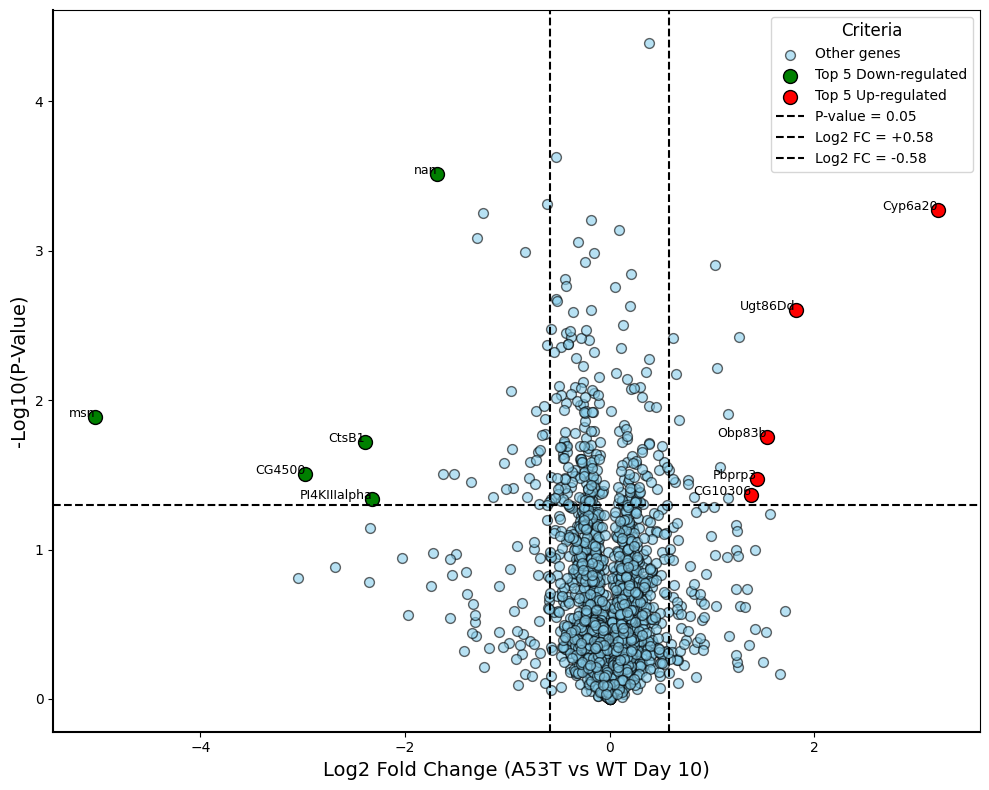

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Phartyma/Python-Biology-Finals/refs/heads/main/Alpha%20synuclein%20Final%20Project.%20Log%20transformed.csv'
df = pd.read_csv(url)

# --- Start of suggested changes ---
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Replace '#VALUE!' with NaN and convert relevant columns to numeric
# First, identify all columns that are expected to be numeric (excluding 'Gene ID' if it exists)
numeric_cols = [col for col in df.columns if col not in ['Gene ID']]

# Replace '#VALUE!' string in these columns and then convert to numeric
for col in numeric_cols:
    df[col] = df[col].replace('#VALUE!', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Print actual column names for verification
print("DataFrame Columns after cleaning:", df.columns.tolist())
# --- End of suggested changes ---

# Calculate mean for WT and A30P replicates
df['WT_Mean'] = df[['WT_D10_1', 'WT_D10_2']].mean(axis=1)
df['A53T_Mean'] = df[['A53T_D10_1', 'A53T_D10_2']].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['A30P_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['A53T_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['WT_D10_1', 'WT_D10_2']].values,
    df[['A53T_D10_1', 'A53T_D10_2']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# Define significance thresholds
p_threshold = 0.05
fc_threshold = 0.58

# Filter for all significant genes first based on both P-value and Fold Change thresholds
significant_genes_df = df[(df['P_Value'] < p_threshold) & (abs(df['Log2_FC']) >= fc_threshold)]

# Get top 5 down-regulated genes (most negative Log2_FC) from the significant genes
top_5_down_regulated = significant_genes_df[significant_genes_df['Log2_FC'] < -fc_threshold].nsmallest(5, 'Log2_FC')

# Get top 5 up-regulated genes (most positive Log2_FC) from the significant genes
top_5_up_regulated = significant_genes_df[significant_genes_df['Log2_FC'] >= fc_threshold].nlargest(5, 'Log2_FC')

# Combine these for labeling on the plot
top_genes = pd.concat([top_5_down_regulated, top_5_up_regulated])

# Create the volcano plot
plt.figure(figsize=(10, 8))

# Plot all genes as 'Other genes' (this includes non-significant and significant but not top 5)
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB', label='Other genes')

# Highlight only the top 5 down-regulated genes
plt.scatter(top_5_down_regulated['Log2_FC'], top_5_down_regulated['MinusLog10_P'], color='green', s=100, edgecolor='black', marker='o', label='Top 5 Down-regulated')

# Highlight only the top 5 up-regulated genes
plt.scatter(top_5_up_regulated['Log2_FC'], top_5_up_regulated['MinusLog10_P'], color='red', s=100, edgecolor='black', marker='o', label='Top 5 Up-regulated')

# Add gene labels for the actual top 5 up and down regulated genes
for _, row in top_genes.iterrows():
    # Assuming 'Gene ID' is the correct column for gene names
    if 'Gene ID' in row.index:
        plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene ID'], fontsize=9, ha='right')
    else:
        # Fallback if 'Gene ID' is not present, though it should be after loading the CSV
        plt.text(row['Log2_FC'], row['MinusLog10_P'], "Unknown Gene", fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(p_threshold), color='black', linestyle='--', label=f'P-value = {p_threshold}')
plt.axvline(fc_threshold, color='black', linestyle='--', label=f'Log2 FC = +{fc_threshold}')
plt.axvline(-fc_threshold, color='black', linestyle='--', label=f'Log2 FC = -{fc_threshold}')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (A53T vs WT Day 10)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('volcano_plot2b.pdf')

# Show the plot
plt.show()

DataFrame Columns after cleaning: ['Gene ID', 'WT_D1_1', 'WT_D1_2', 'WT_D10_1', 'WT_D10_2', 'WT_D30_1', 'WT_D30_2', 'A30P_D1_1', 'A30P_D1_2', 'A30P_D10_1', 'A30P_D10_2', 'A53T_D1_1', 'A53T_D1_2', 'A53T_D10_1', 'A53T_D10_2', 'A53T_D30_1', 'A53T_D30_2']


/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df
/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


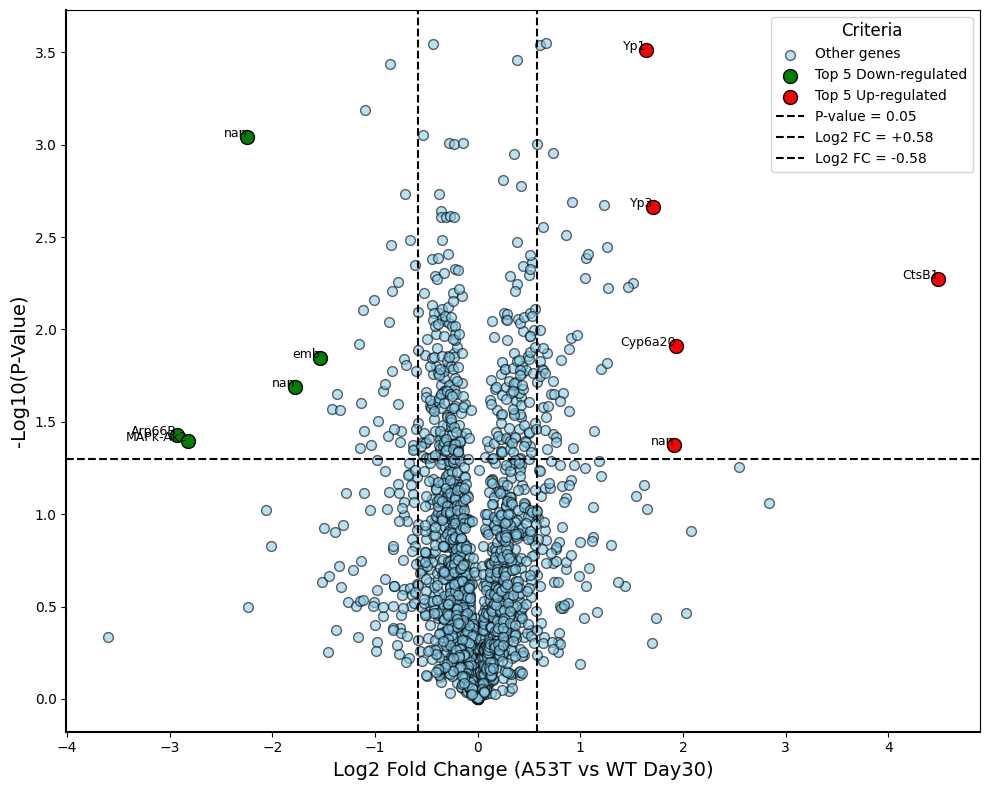

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Phartyma/Python-Biology-Finals/refs/heads/main/Alpha%20synuclein%20Final%20Project.%20Log%20transformed.csv'
df = pd.read_csv(url)

# --- Start of suggested changes ---
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Replace '#VALUE!' with NaN and convert relevant columns to numeric
# First, identify all columns that are expected to be numeric (excluding 'Gene ID' if it exists)
numeric_cols = [col for col in df.columns if col not in ['Gene ID']]

# Replace '#VALUE!' string in these columns and then convert to numeric
for col in numeric_cols:
    df[col] = df[col].replace('#VALUE!', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Print actual column names for verification
print("DataFrame Columns after cleaning:", df.columns.tolist())
# --- End of suggested changes ---

# Calculate mean for WT and A30P replicates
df['WT_Mean'] = df[['WT_D30_1', 'WT_D30_2']].mean(axis=1)
df['A53T_Mean'] = df[['A53T_D30_1', 'A53T_D30_2']].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['A30P_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['A53T_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['WT_D30_1', 'WT_D30_2']].values,
    df[['A53T_D30_1', 'A53T_D30_2']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# Define significance thresholds
p_threshold = 0.05
fc_threshold = 0.58

# Filter for all significant genes first based on both P-value and Fold Change thresholds
significant_genes_df = df[(df['P_Value'] < p_threshold) & (abs(df['Log2_FC']) >= fc_threshold)]

# Get top 5 down-regulated genes (most negative Log2_FC) from the significant genes
top_5_down_regulated = significant_genes_df[significant_genes_df['Log2_FC'] < -fc_threshold].nsmallest(5, 'Log2_FC')

# Get top 5 up-regulated genes (most positive Log2_FC) from the significant genes
top_5_up_regulated = significant_genes_df[significant_genes_df['Log2_FC'] >= fc_threshold].nlargest(5, 'Log2_FC')

# Combine these for labeling on the plot
top_genes = pd.concat([top_5_down_regulated, top_5_up_regulated])

# Create the volcano plot
plt.figure(figsize=(10, 8))

# Plot all genes as 'Other genes' (this includes non-significant and significant but not top 5)
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB', label='Other genes')

# Highlight only the top 5 down-regulated genes
plt.scatter(top_5_down_regulated['Log2_FC'], top_5_down_regulated['MinusLog10_P'], color='green', s=100, edgecolor='black', marker='o', label='Top 5 Down-regulated')

# Highlight only the top 5 up-regulated genes
plt.scatter(top_5_up_regulated['Log2_FC'], top_5_up_regulated['MinusLog10_P'], color='red', s=100, edgecolor='black', marker='o', label='Top 5 Up-regulated')

# Add gene labels for the actual top 5 up and down regulated genes
for _, row in top_genes.iterrows():
    # Assuming 'Gene ID' is the correct column for gene names
    if 'Gene ID' in row.index:
        plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene ID'], fontsize=9, ha='right')
    else:
        # Fallback if 'Gene ID' is not present, though it should be after loading the CSV
        plt.text(row['Log2_FC'], row['MinusLog10_P'], "Unknown Gene", fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(p_threshold), color='black', linestyle='--', label=f'P-value = {p_threshold}')
plt.axvline(fc_threshold, color='black', linestyle='--', label=f'Log2 FC = +{fc_threshold}')
plt.axvline(-fc_threshold, color='black', linestyle='--', label=f'Log2 FC = -{fc_threshold}')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (A53T vs WT Day30)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('volcano_plot2c.pdf')

# Show the plot
plt.show()

DataFrame Columns after cleaning: ['Gene ID', 'WT_D1_1', 'WT_D1_2', 'WT_D10_1', 'WT_D10_2', 'WT_D30_1', 'WT_D30_2', 'A30P_D1_1', 'A30P_D1_2', 'A30P_D10_1', 'A30P_D10_2', 'A53T_D1_1', 'A53T_D1_2', 'A53T_D10_1', 'A53T_D10_2', 'A53T_D30_1', 'A53T_D30_2']


/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df
/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


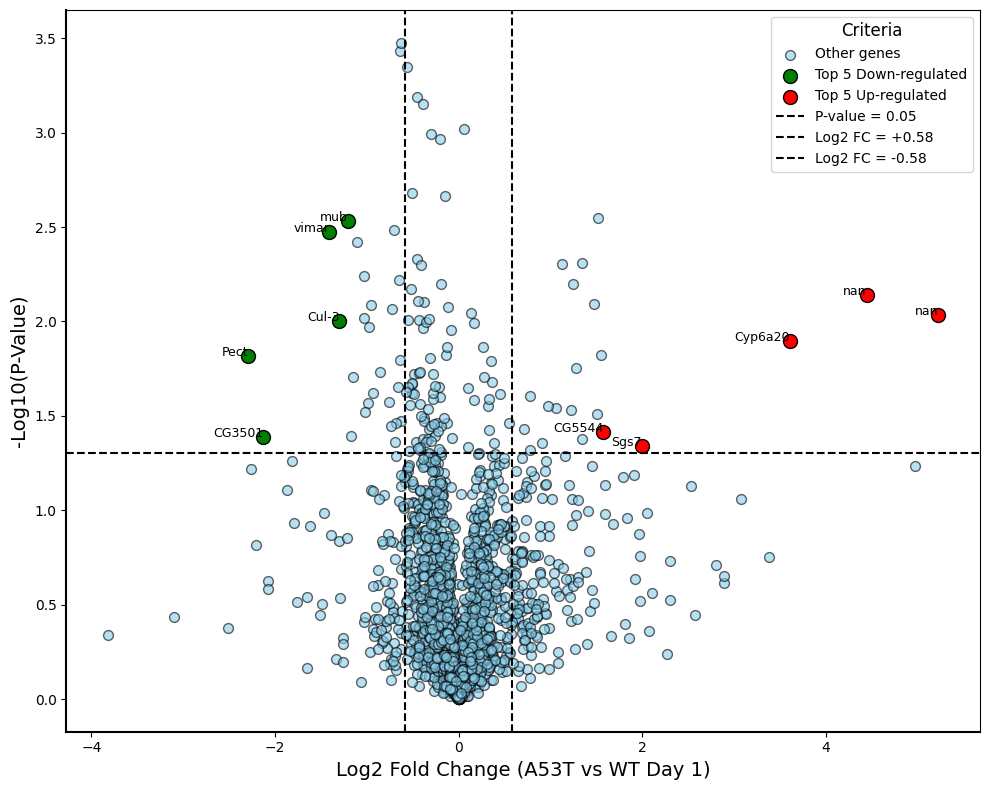

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Phartyma/Python-Biology-Finals/refs/heads/main/Alpha%20synuclein%20Final%20Project.%20Log%20transformed.csv'
df = pd.read_csv(url)

# --- Start of suggested changes ---
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Replace '#VALUE!' with NaN and convert relevant columns to numeric
# First, identify all columns that are expected to be numeric (excluding 'Gene ID' if it exists)
numeric_cols = [col for col in df.columns if col not in ['Gene ID']]

# Replace '#VALUE!' string in these columns and then convert to numeric
for col in numeric_cols:
    df[col] = df[col].replace('#VALUE!', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Print actual column names for verification
print("DataFrame Columns after cleaning:", df.columns.tolist())
# --- End of suggested changes ---

# Calculate mean for WT and A30P replicates
df['WT_Mean'] = df[['WT_D1_1', 'WT_D1_2']].mean(axis=1)
df['A53T_Mean'] = df[['A53T_D1_1', 'A53T_D1_2']].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['A30P_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['A53T_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['WT_D1_1', 'WT_D1_2']].values,
    df[['A53T_D1_1', 'A53T_D1_2']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# Define significance thresholds
p_threshold = 0.05
fc_threshold = 0.58

# Filter for all significant genes first based on both P-value and Fold Change thresholds
significant_genes_df = df[(df['P_Value'] < p_threshold) & (abs(df['Log2_FC']) >= fc_threshold)]

# Get top 5 down-regulated genes (most negative Log2_FC) from the significant genes
top_5_down_regulated = significant_genes_df[significant_genes_df['Log2_FC'] < -fc_threshold].nsmallest(5, 'Log2_FC')

# Get top 5 up-regulated genes (most positive Log2_FC) from the significant genes
top_5_up_regulated = significant_genes_df[significant_genes_df['Log2_FC'] >= fc_threshold].nlargest(5, 'Log2_FC')

# Combine these for labeling on the plot
top_genes = pd.concat([top_5_down_regulated, top_5_up_regulated])

# Create the volcano plot
plt.figure(figsize=(10, 8))

# Plot all genes as 'Other genes' (this includes non-significant and significant but not top 5)
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB', label='Other genes')

# Highlight only the top 5 down-regulated genes
plt.scatter(top_5_down_regulated['Log2_FC'], top_5_down_regulated['MinusLog10_P'], color='green', s=100, edgecolor='black', marker='o', label='Top 5 Down-regulated')

# Highlight only the top 5 up-regulated genes
plt.scatter(top_5_up_regulated['Log2_FC'], top_5_up_regulated['MinusLog10_P'], color='red', s=100, edgecolor='black', marker='o', label='Top 5 Up-regulated')

# Add gene labels for the actual top 5 up and down regulated genes
for _, row in top_genes.iterrows():
    # Assuming 'Gene ID' is the correct column for gene names
    if 'Gene ID' in row.index:
        plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene ID'], fontsize=9, ha='right')
    else:
        # Fallback if 'Gene ID' is not present, though it should be after loading the CSV
        plt.text(row['Log2_FC'], row['MinusLog10_P'], "Unknown Gene", fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(p_threshold), color='black', linestyle='--', label=f'P-value = {p_threshold}')
plt.axvline(fc_threshold, color='black', linestyle='--', label=f'Log2 FC = +{fc_threshold}')
plt.axvline(-fc_threshold, color='black', linestyle='--', label=f'Log2 FC = -{fc_threshold}')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (A53T vs WT Day 1)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('volcano_plot2d.pdf')

# Show the plot
plt.show()

DataFrame Columns after cleaning: ['Gene ID', 'WT_D1_1', 'WT_D1_2', 'WT_D10_1', 'WT_D10_2', 'WT_D30_1', 'WT_D30_2', 'A30P_D1_1', 'A30P_D1_2', 'A30P_D10_1', 'A30P_D10_2', 'A53T_D1_1', 'A53T_D1_2', 'A53T_D10_1', 'A53T_D10_2', 'A53T_D30_1', 'A53T_D30_2']


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


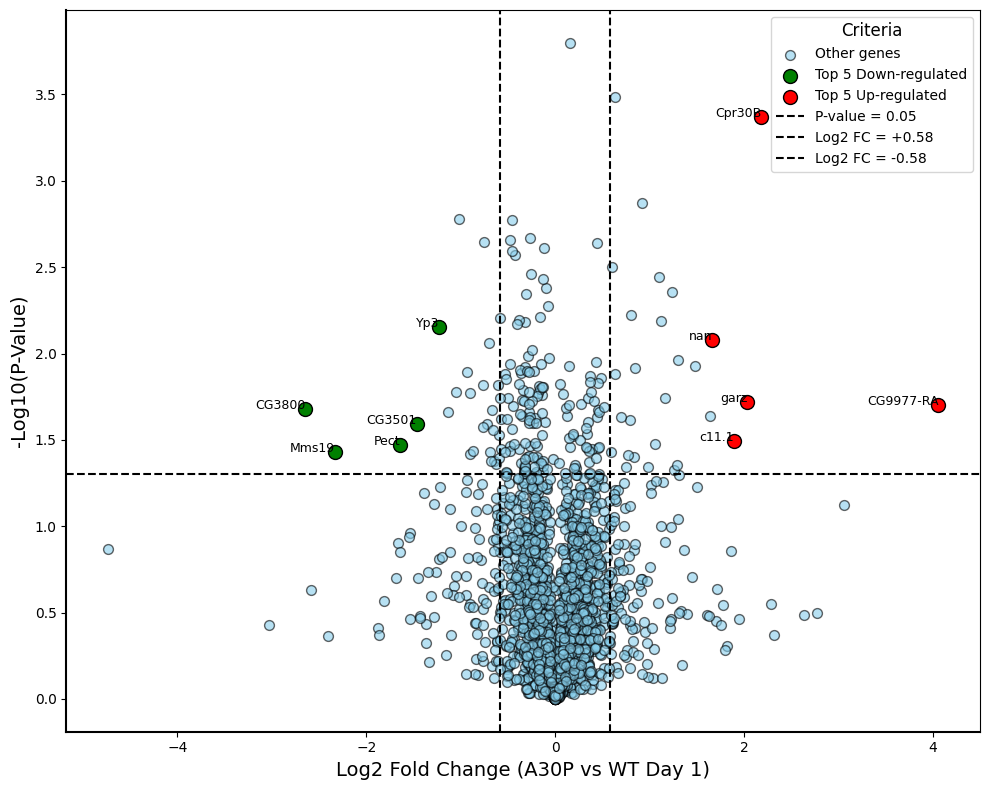

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Phartyma/Python-Biology-Finals/refs/heads/main/Alpha%20synuclein%20Final%20Project.%20Log%20transformed.csv'
df = pd.read_csv(url)

# --- Start of suggested changes ---
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Replace '#VALUE!' with NaN and convert relevant columns to numeric
# First, identify all columns that are expected to be numeric (excluding 'Gene ID' if it exists)
numeric_cols = [col for col in df.columns if col not in ['Gene ID']]

# Replace '#VALUE!' string in these columns and then convert to numeric
for col in numeric_cols:
    df[col] = df[col].replace('#VALUE!', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Print actual column names for verification
print("DataFrame Columns after cleaning:", df.columns.tolist())
# --- End of suggested changes ---

# Calculate mean for WT and A30P replicates
df['WT_Mean'] = df[['WT_D1_1', 'WT_D1_2']].mean(axis=1)
df['A30P_Mean'] = df[['A30P_D1_1', 'A30P_D1_2']].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['A30P_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['A30P_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['WT_D1_1', 'WT_D1_2']].values,
    df[['A30P_D1_1', 'A30P_D1_2']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# Define significance thresholds
p_threshold = 0.05
fc_threshold = 0.58

# Filter for all significant genes first based on both P-value and Fold Change thresholds
significant_genes_df = df[(df['P_Value'] < p_threshold) & (abs(df['Log2_FC']) >= fc_threshold)]

# Get top 5 down-regulated genes (most negative Log2_FC) from the significant genes
top_5_down_regulated = significant_genes_df[significant_genes_df['Log2_FC'] < -fc_threshold].nsmallest(5, 'Log2_FC')

# Get top 5 up-regulated genes (most positive Log2_FC) from the significant genes
top_5_up_regulated = significant_genes_df[significant_genes_df['Log2_FC'] >= fc_threshold].nlargest(5, 'Log2_FC')

# Combine these for labeling on the plot
top_genes = pd.concat([top_5_down_regulated, top_5_up_regulated])

# Create the volcano plot
plt.figure(figsize=(10, 8))

# Plot all genes as 'Other genes' (this includes non-significant and significant but not top 5)
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB', label='Other genes')

# Highlight only the top 5 down-regulated genes
plt.scatter(top_5_down_regulated['Log2_FC'], top_5_down_regulated['MinusLog10_P'], color='green', s=100, edgecolor='black', marker='o', label='Top 5 Down-regulated')

# Highlight only the top 5 up-regulated genes
plt.scatter(top_5_up_regulated['Log2_FC'], top_5_up_regulated['MinusLog10_P'], color='red', s=100, edgecolor='black', marker='o', label='Top 5 Up-regulated')

# Add gene labels for the actual top 5 up and down regulated genes
for _, row in top_genes.iterrows():
    # Assuming 'Gene ID' is the correct column for gene names
    if 'Gene ID' in row.index:
        plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene ID'], fontsize=9, ha='right')
    else:
        # Fallback if 'Gene ID' is not present, though it should be after loading the CSV
        plt.text(row['Log2_FC'], row['MinusLog10_P'], "Unknown Gene", fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(p_threshold), color='black', linestyle='--', label=f'P-value = {p_threshold}')
plt.axvline(fc_threshold, color='black', linestyle='--', label=f'Log2 FC = +{fc_threshold}')
plt.axvline(-fc_threshold, color='black', linestyle='--', label=f'Log2 FC = -{fc_threshold}')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (A30P vs WT Day 1)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('volcano_plote.pdf')

# Show the plot
plt.show()

DataFrame Columns after cleaning: ['Gene ID', 'WT_D1_1', 'WT_D1_2', 'WT_D10_1', 'WT_D10_2', 'WT_D30_1', 'WT_D30_2', 'A30P_D1_1', 'A30P_D1_2', 'A30P_D10_1', 'A30P_D10_2', 'A53T_D1_1', 'A53T_D1_2', 'A53T_D10_1', 'A53T_D10_2', 'A53T_D30_1', 'A53T_D30_2']


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


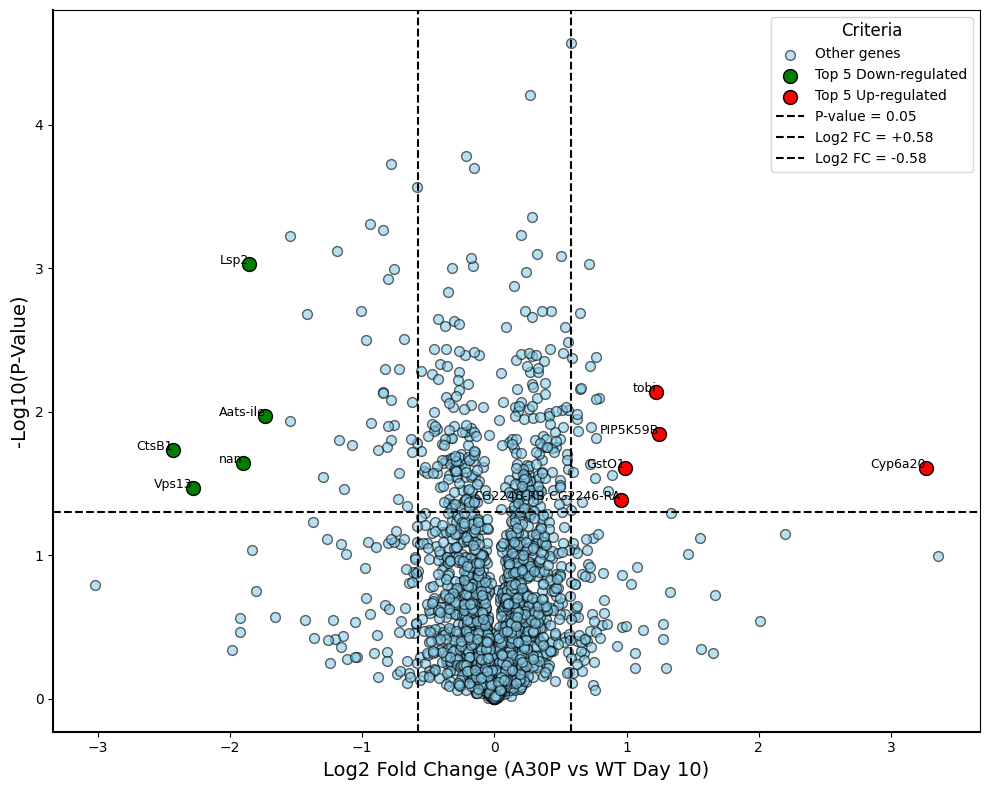

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Phartyma/Python-Biology-Finals/refs/heads/main/Alpha%20synuclein%20Final%20Project.%20Log%20transformed.csv'
df = pd.read_csv(url)

# --- Start of suggested changes ---
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Replace '#VALUE!' with NaN and convert relevant columns to numeric
# First, identify all columns that are expected to be numeric (excluding 'Gene ID' if it exists)
numeric_cols = [col for col in df.columns if col not in ['Gene ID']]

# Replace '#VALUE!' string in these columns and then convert to numeric
for col in numeric_cols:
    df[col] = df[col].replace('#VALUE!', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Print actual column names for verification
print("DataFrame Columns after cleaning:", df.columns.tolist())
# --- End of suggested changes ---

# Calculate mean for WT and A30P replicates
df['WT_Mean'] = df[['WT_D10_1', 'WT_D10_2']].mean(axis=1)
df['A30P_Mean'] = df[['A30P_D10_1', 'A30P_D10_2']].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['A30P_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['A30P_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['WT_D10_1', 'WT_D10_2']].values,
    df[['A30P_D10_1', 'A30P_D10_2']].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# Define significance thresholds
p_threshold = 0.05
fc_threshold = 0.58

# Filter for all significant genes first based on both P-value and Fold Change thresholds
significant_genes_df = df[(df['P_Value'] < p_threshold) & (abs(df['Log2_FC']) >= fc_threshold)]

# Get top 5 down-regulated genes (most negative Log2_FC) from the significant genes
top_5_down_regulated = significant_genes_df[significant_genes_df['Log2_FC'] < -fc_threshold].nsmallest(5, 'Log2_FC')

# Get top 5 up-regulated genes (most positive Log2_FC) from the significant genes
top_5_up_regulated = significant_genes_df[significant_genes_df['Log2_FC'] >= fc_threshold].nlargest(5, 'Log2_FC')

# Combine these for labeling on the plot
top_genes = pd.concat([top_5_down_regulated, top_5_up_regulated])

# Create the volcano plot
plt.figure(figsize=(10, 8))

# Plot all genes as 'Other genes' (this includes non-significant and significant but not top 5)
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB', label='Other genes')

# Highlight only the top 5 down-regulated genes
plt.scatter(top_5_down_regulated['Log2_FC'], top_5_down_regulated['MinusLog10_P'], color='green', s=100, edgecolor='black', marker='o', label='Top 5 Down-regulated')

# Highlight only the top 5 up-regulated genes
plt.scatter(top_5_up_regulated['Log2_FC'], top_5_up_regulated['MinusLog10_P'], color='red', s=100, edgecolor='black', marker='o', label='Top 5 Up-regulated')

# Add gene labels for the actual top 5 up and down regulated genes
for _, row in top_genes.iterrows():
    # Assuming 'Gene ID' is the correct column for gene names
    if 'Gene ID' in row.index:
        plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Gene ID'], fontsize=9, ha='right')
    else:
        # Fallback if 'Gene ID' is not present, though it should be after loading the CSV
        plt.text(row['Log2_FC'], row['MinusLog10_P'], "Unknown Gene", fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(p_threshold), color='black', linestyle='--', label=f'P-value = {p_threshold}')
plt.axvline(fc_threshold, color='black', linestyle='--', label=f'Log2 FC = +{fc_threshold}')
plt.axvline(-fc_threshold, color='black', linestyle='--', label=f'Log2 FC = -{fc_threshold}')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (A30P vs WT Day 10)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()

# Save the plot as a PDF
plt.savefig('volcano_plotf.pdf')

# Show the plot
plt.show()